---
> # <b><font color = "Blue">Loan Default - Exploratory Data Analysis</font> </b>

>> **Analyst:** Sabarish <br>
>> **Email:** [sabarish.analytics@gmail.com](mailto:selvamsabarish1998@gmail.com)  
>> **LinkedIn:** [Sabarish Selvam](https://www.linkedin.com/in/sabarishselvam/)  
>> **Date of Completion:** 2024-11-21
---

### **1. Data Dictionary**





- **ID**: Unique identifier for each row of data.
- **Year**: The year when the loan was taken.
- **Loan Limit**: Indicates whether the loan limit is fixed or variable.
  - `cf` - Confirmed / Fixed loan limit
  - `ncf` - Not Confirmed / Not Fixed loan limit
- **Gender**: Gender of the applicant.
  - Options: `male`, `female`, `not specified`, `joint` (in case of a couple applying for a home loan).
- **Loan Type**: Type of loan (masked data).
  - Options: `type-1`, `type-2`, `type-3`.
- **Loan Purpose**: Purpose of the loan (masked data).
  - Options: `p1`, `p2`, `p3`, `p4`.
- **Business or Commercial**: Indicates whether the loan is for a commercial establishment or personal establishment.
- **Loan Amount**: The total amount of the loan.
- **Rate of Interest**: The interest rate applied to the loan.
- **Upfront Charges**: The down payment made by the applicant at the time of loan approval.
- **Property Value**: The value of the property being constructed or purchased with the loan.
- **Occupancy Type**: The type of establishment for which the loan is taken.
- **Income**: The annual income of the applicant.
- **Credit Type**: The credit type associated with the applicant.
  - Options: `EXP`, `EQUI`, `CRIF`, `CIB`.
- **Credit Score**: The applicant's credit score.
- **Co-Applicant Credit Type**: The credit type for the co-applicant, if applicable.
- **Age**: The age of the applicant.
- **LTV (Loan-To-Value)**: The lifetime value of the applicant.
- **Region**: The geographical region where the applicant resides.
- **Status**: The loan status.
  - `1` - Defaulter
  - `0` - Normal
---


### **2. Pre-Requisites**

In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import display, Markdown
import scipy.stats as stats
import re
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, ttest_ind



# Set display options for pandas
# '''
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# '''
# Suppress only RuntimeWarnings

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Ensure matplotlib plots are rendered inline
#%matplotlib inline

# File path of the CSV file
#url = r"C:\Users\Sabarish.S\Downloads\loan.csv"

### **3. Data Import**

In [2]:
# Read the CSV file into a pandas DataFrame with specified data types
link = "https://raw.githubusercontent.com/DSabarish/loan-default-analysis/refs/heads/main/loan%20(1).csv"
df = pd.read_csv(link)

In [3]:
df.head()

,ID,year,loan_limit,Gender,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,Upfront_charges,property_value,occupancy_type,income,credit_type,Credit_Score,co-applicant_credit_type,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,type1,p1,nob/c,116500,NaN,NaN,118000.0,pr,1740.0,EXP,758,CIB,25-34,98.728814,south,1
1,24891,2019,cf,Male,type2,p1,b/c,206500,NaN,NaN,NaN,pr,4980.0,EQUI,552,EXP,55-64,NaN,North,1
2,24892,2019,cf,Male,type1,p1,nob/c,406500,4.56,595.0,508000.0,pr,9480.0,EXP,834,CIB,35-44,80.019685,south,0
3,24893,2019,cf,Male,type1,p4,nob/c,456500,4.25,NaN,658000.0,pr,11880.0,EXP,587,CIB,45-54,69.376900,North,0
4,24894,2019,cf,Joint,type1,p1,nob/c,696500,4.00,0.0,758000.0,pr,10440.0,CRIF,602,EXP,25-34,91.886544,North,0


### **4. Helper Function**

In [4]:
# Function to print basic useful details for a given column
def get_column_details(df,column):
    print("Details of",column,"column")

    #DataType of column
    print("\nDataType: ",df[column].dtype)

    #Check if null values are present
    count_null = df[column].isnull().sum()
    if count_null==0:
        print("\nThere are no null values")
    elif count_null>0:
        print("\nThere are ",count_null," null values")

    #Get Number of Unique Values
    print("\nNumber of Unique Values: ",df[column].nunique())

    #Get Distribution of Column
    print("\nDistribution of column:\n")
    print(df[column].value_counts())


def fill_missing_with_group_mode(df, groupby, column):
    print("\nNo. of missing values before filling with group mode:",df[column].isnull().sum())

    # Assign None to np.NaN
    if df[column].isin([None]).sum():
            df[column][df[column].isin([None])] = np.NaN

    # Fill with local mode
    mode_per_group = df.groupby(groupby)[column].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    df[column] = df[column].fillna(mode_per_group)

    print("\nNo. of missing values after filling with group mode:",df[column].isnull().sum())


def df_describe(df):
    df.describe().T
    d = df.describe().T
    d["no. of nulls"] = df.shape[0]-d["count"]
    d["prt of nulls"] = (d["no. of nulls"] / df.shape[0] * 100)
    return d.round(2)


def chi_square_test(df, col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2])
    crosstab_melted = crosstab.reset_index().melt(id_vars=[col1], var_name=col2, value_name='Count')

    plt.figure(figsize=(6, 4))
    sns.barplot(x=col1, y='Count', hue=col2, data=crosstab_melted)
    plt.title(f'{col1} vs {col2}')
    plt.xlabel(col1)
    plt.ylabel('Count')
    plt.show()

    chi2, p_value, _, _ = chi2_contingency(crosstab)
    result = " 🔴 Reject" if p_value < 0.05 else "🟢 Fail to Reject"
    inference = "There is a significant relationship between" if p_value < 0.05 else "No significant relationship between"
    print(f"Chi-Square Test: {col1} vs {col2} | Chi2: {chi2:.4f}, p-value: {p_value:.4f} -> {result} Null Hypothesis")
    print(f"Inference: {inference} {col1} and {col2}.\n")


def ttest(df, col1, col2):
    groups = df[col2].unique()
    group1 = df[df[col2] == groups[0]][col1]
    group2 = df[df[col2] == groups[1]][col1]

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=col2, y=col1, data=df)
    plt.title(f'{col1} by {col2}')
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.show()

    t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
    result = " 🔴 Reject" if p_value < 0.05 else "🟢 Fail to Reject"
    inference = "There is a significant difference in" if p_value < 0.05 else "No significant difference in"
    print(f"T-Test: {col1} vs {col2} | T-stat: {t_stat:.4f}, p-value: {p_value:.4f} -> {result} Null Hypothesis")
    print(f"Inference: {inference} {col1} between {groups[0]} and {groups[1]}.\n")


# Function to remove outliers using IQR
def clean_dataframe_outliers(df):
    numeric_cols = ['loan_amount', 'rate_of_interest', 'Upfront_charges', 'property_value', 'income', 'Credit_Score']
    df_cleaned = df.copy()
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

### **Checking the Structure and Characterestics of data**

In [5]:
df.shape

(148670, 20)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        148670 non-null  int64  
 1   year                      148670 non-null  int64  
 2   loan_limit                145326 non-null  object 
 3   Gender                    148670 non-null  object 
 4   loan_type                 148670 non-null  object 
 5   loan_purpose              148536 non-null  object 
 6   business_or_commercial    148670 non-null  object 
 7   loan_amount               148670 non-null  int64  
 8   rate_of_interest          112231 non-null  float64
 9   Upfront_charges           109028 non-null  float64
 10  property_value            133572 non-null  float64
 11  occupancy_type            148670 non-null  object 
 12  income                    139520 non-null  float64
 13  credit_type               148670 non-null  o

In [7]:
# Categorical Columns Info
df.describe(exclude=np.number).T

,count,unique,top,freq
loan_limit,145326,2,cf,135348
Gender,148670,4,Male,42346
loan_type,148670,3,type1,113173
loan_purpose,148536,4,p3,55934
business_or_commercial,148670,2,nob/c,127908
occupancy_type,148670,3,pr,138201
credit_type,148670,4,CIB,48152
co-applicant_credit_type,148670,2,CIB,74392
age,148470,7,45-54,34720
Region,148670,4,North,74722


In [8]:
# Numerical Columns Info
df_describe(df)

,count,mean,std,min,25%,50%,75%,max,no. of nulls,prt of nulls
ID,148670.0,99224.50,42917.48,24890.00,62057.25,99224.50,136391.75,173559.00,0.0,0.00
year,148670.0,2019.00,0.00,2019.00,2019.00,2019.00,2019.00,2019.00,0.0,0.00
loan_amount,148670.0,331117.74,183909.31,16500.00,196500.00,296500.00,436500.00,3576500.00,0.0,0.00
rate_of_interest,112231.0,4.05,0.56,0.00,3.62,3.99,4.38,8.00,36439.0,24.51
Upfront_charges,109028.0,3225.00,3251.12,0.00,581.49,2596.45,4812.50,60000.00,39642.0,26.66
property_value,133572.0,497893.47,359935.32,8000.00,268000.00,418000.00,628000.00,16508000.00,15098.0,10.16
income,139520.0,6957.34,6496.59,0.00,3720.00,5760.00,8520.00,578580.00,9150.0,6.15
Credit_Score,148670.0,699.79,115.88,500.00,599.00,699.00,800.00,900.00,0.0,0.00
LTV,133572.0,72.75,39.97,0.97,60.47,75.14,86.18,7831.25,15098.0,10.16
Status,148670.0,0.25,0.43,0.00,0.00,0.00,0.00,1.00,0.0,0.00


In [9]:
for i in df.columns:
  print("\n#################################\n")
  print(i)
  get_column_details(df,i)


#################################

ID
Details of ID column

DataType:  int64

There are no null values

Number of Unique Values:  148670

Distribution of column:

ID
24890     1
123979    1
123999    1
124000    1
124001    1
         ..
74447     1
74448     1
74449     1
74450     1
173559    1
Name: count, Length: 148670, dtype: int64

#################################

year
Details of year column

DataType:  int64

There are no null values

Number of Unique Values:  1

Distribution of column:

year
2019    148670
Name: count, dtype: int64

#################################

loan_limit
Details of loan_limit column

DataType:  object

There are  3344  null values

Number of Unique Values:  2

Distribution of column:

loan_limit
cf     135348
ncf      9978
Name: count, dtype: int64

#################################

Gender
Details of Gender column

DataType:  object

There are no null values

Number of Unique Values:  4

Distribution of column:

Gender
Male                 42346
Joi

### **5. Data Cleaning**

In [10]:
# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()

In [11]:
df['year'].unique()
#The dataset clearly represents only "2019", making the year column redundant; therefore, it will be dropped
df.drop(columns=['year'], inplace=True)

In [12]:
df['business_or_commercial']=df['business_or_commercial'].apply(lambda x: 0 if x=='nob/c' else 1)

In [13]:
df.describe(exclude=np.number).T

,count,unique,top,freq
loan_limit,145326,2,cf,135348
Gender,148670,4,Male,42346
loan_type,148670,3,type1,113173
loan_purpose,148536,4,p3,55934
occupancy_type,148670,3,pr,138201
credit_type,148670,4,CIB,48152
co-applicant_credit_type,148670,2,CIB,74392
age,148470,7,45-54,34720
Region,148670,4,North,74722


In [14]:
df_describe(df)

,count,mean,std,min,25%,50%,75%,max,no. of nulls,prt of nulls
ID,148670.0,99224.50,42917.48,24890.00,62057.25,99224.50,136391.75,173559.00,0.0,0.00
business_or_commercial,148670.0,0.14,0.35,0.00,0.00,0.00,0.00,1.00,0.0,0.00
loan_amount,148670.0,331117.74,183909.31,16500.00,196500.00,296500.00,436500.00,3576500.00,0.0,0.00
rate_of_interest,112231.0,4.05,0.56,0.00,3.62,3.99,4.38,8.00,36439.0,24.51
Upfront_charges,109028.0,3225.00,3251.12,0.00,581.49,2596.45,4812.50,60000.00,39642.0,26.66
property_value,133572.0,497893.47,359935.32,8000.00,268000.00,418000.00,628000.00,16508000.00,15098.0,10.16
income,139520.0,6957.34,6496.59,0.00,3720.00,5760.00,8520.00,578580.00,9150.0,6.15
Credit_Score,148670.0,699.79,115.88,500.00,599.00,699.00,800.00,900.00,0.0,0.00
LTV,133572.0,72.75,39.97,0.97,60.47,75.14,86.18,7831.25,15098.0,10.16
Status,148670.0,0.25,0.43,0.00,0.00,0.00,0.00,1.00,0.0,0.00


### **5.1 - Handling Nulls & Imputation**

> ##### loan_limit

In [15]:
col = "loan_limit"
grp_col = ["loan_type", "loan_purpose", "business_or_commercial", "occupancy_type" , "age"]
fill_missing_with_group_mode(df, groupby = grp_col, column = col)


No. of missing values before filling with group mode: 3344

No. of missing values after filling with group mode: 12


> ##### rate_of_interest

In [16]:
col = "rate_of_interest"
grp_col = ["loan_type", "loan_purpose", "business_or_commercial", "occupancy_type" , "age"]
fill_missing_with_group_mode(df, groupby = grp_col, column = col)


No. of missing values before filling with group mode: 36439

No. of missing values after filling with group mode: 47


> ##### Upfront_charges

In [17]:
col = "Upfront_charges"
grp_col = ["loan_limit","loan_type", "loan_purpose","business_or_commercial", "occupancy_type"]
fill_missing_with_group_mode(df, groupby = grp_col, column = col)


No. of missing values before filling with group mode: 39642

No. of missing values after filling with group mode: 44


> ##### property_value

In [18]:
df["flag_no_property"] = np.where(df["property_value"].isnull() | (df["property_value"] <= 0), "No Property", "Property")
df["flag_no_property"].value_counts()

df.groupby(["flag_no_property","Status"])["Status"].count()

flag_no_property  Status
No Property       0              2
                  1          15096
Property          0         112029
                  1          21543
Name: Status, dtype: int64

---

**Note:** We are not imputing the missing values in the `property_value` column, as this is a customer-specific monetary feature.  
We lack confidence in reliably imputing these values without introducing bias or incorrect assumptions.

**Assumption:** Missing (`null`) values in the `property_value` column are treated as indicating that the customer does not own a property,  
i.e., they are classified as "No Property."

---

In [19]:
df["property_value"] = np.where(df["property_value"].isnull() | (df["property_value"] <= 0), 0, df["property_value"])

> ##### LTV

In [20]:
col = "LTV"
grp_col = ['loan_limit', 'loan_type', 'loan_purpose', 'business_or_commercial', 'occupancy_type', 'age']
fill_missing_with_group_mode(df, groupby = grp_col, column = col)


No. of missing values before filling with group mode: 15098

No. of missing values after filling with group mode: 21


> ##### loan_purpose

In [21]:
col = "loan_purpose"
grp_col = ["loan_type", "business_or_commercial", "occupancy_type", "age"]
fill_missing_with_group_mode(df, groupby = grp_col, column = col)


No. of missing values before filling with group mode: 134

No. of missing values after filling with group mode: 8


### **5.2 - Outlier Treatment**

In [22]:
# Capping Outliers from Numerical Cols
df_cleaned = clean_dataframe_outliers(df)

# Check
print(df.Status.value_counts(), df_cleaned.Status.value_counts(),)

Status
0    112031
1     36639
Name: count, dtype: int64 Status
0    87665
1    32329
Name: count, dtype: int64


Visualising Outliers Before - After Treatment

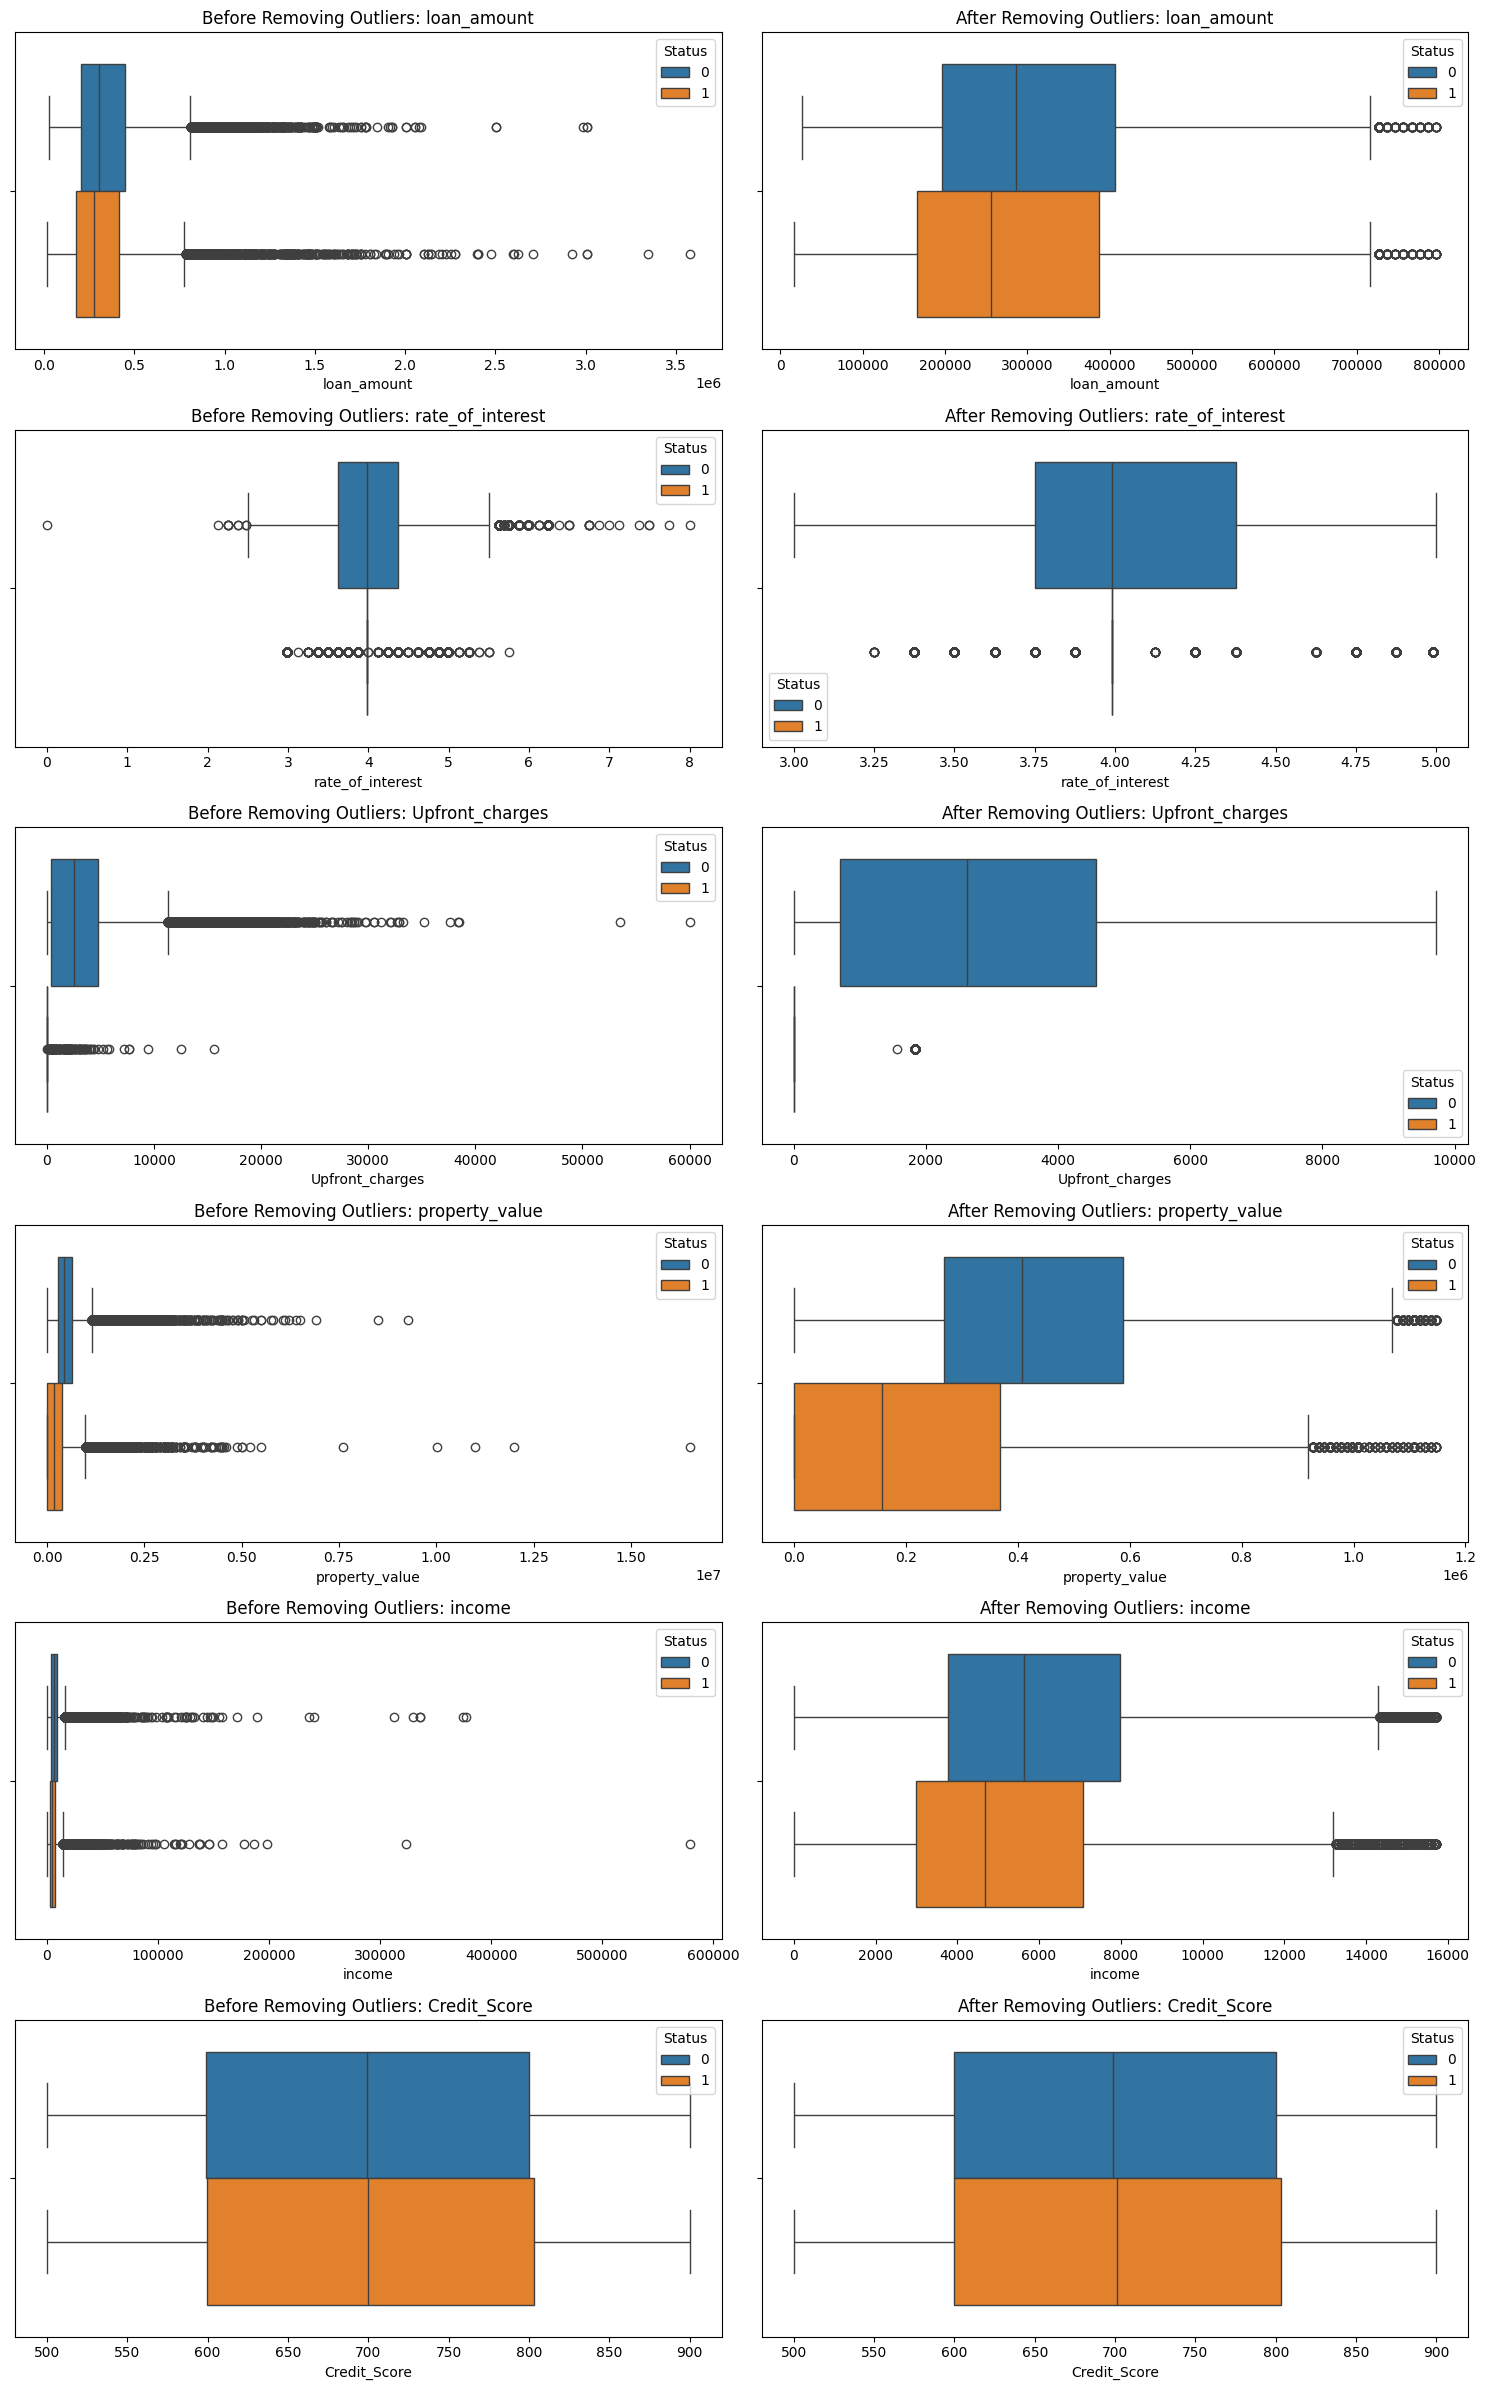

In [23]:
cols = ['loan_amount', 'rate_of_interest', 'Upfront_charges', 'property_value', 'income', 'Credit_Score']

fig, axes = plt.subplots(len(cols), 2, figsize=(15, len(cols) * 4))

for i, col in enumerate(cols):
    # Before removing outliers (left column)
    sns.boxplot(data=df, x=col, ax=axes[i, 0], hue='Status')
    axes[i, 0].set_title(f'Before Removing Outliers: {col}')

    # After removing outliers (right column)
    sns.boxplot(data=df_cleaned, x=col, ax=axes[i, 1], hue='Status')
    axes[i, 1].set_title(f'After Removing Outliers: {col}')

plt.tight_layout()
plt.show()

In [24]:
# Reintialising df to cleaned data without outliers
df = df_cleaned.copy()

display(
    "Categorical Col Info",
df.describe(include = ["O"]).T.round(2),

         "Numerical Col Info",
df.describe(exclude = ["O"]).T.round(2)
         )

'Categorical Col Info'

,count,unique,top,freq
loan_limit,119994,2,cf,113944
Gender,119994,4,Male,34529
loan_type,119994,3,type1,95611
loan_purpose,119994,4,p3,48128
occupancy_type,119994,3,pr,112891
credit_type,119994,4,CIB,38957
co-applicant_credit_type,119994,2,CIB,61842
age,119994,7,45-54,27130
Region,119994,4,North,61052
flag_no_property,119994,2,Property,106310


'Numerical Col Info'

,count,mean,std,min,25%,50%,75%,max
ID,119994.0,99149.45,42949.86,24890.0,61945.25,99145.50,136370.75,173559.00
business_or_commercial,119994.0,0.14,0.34,0.0,0.00,0.00,0.00,1.00
loan_amount,119994.0,304757.91,152354.70,16500.0,186500.00,276500.00,406500.00,796500.00
rate_of_interest,119994.0,4.05,0.42,3.0,3.75,3.99,4.25,5.00
Upfront_charges,119994.0,2130.52,2469.67,0.0,0.00,1190.72,3776.44,9725.00
property_value,119994.0,385341.52,251642.65,0.0,208000.00,358000.00,548000.00,1148000.00
income,119994.0,5932.16,3113.22,0.0,3540.00,5400.00,7800.00,15720.00
Credit_Score,119994.0,699.91,115.81,500.0,600.00,700.00,800.00,900.00
LTV,119994.0,74.37,17.72,5.1,63.94,76.83,87.79,263.54
Status,119994.0,0.27,0.44,0.0,0.00,0.00,1.00,1.00


### **6. EDA begins**

### **6.1 - Univariant Analysis**

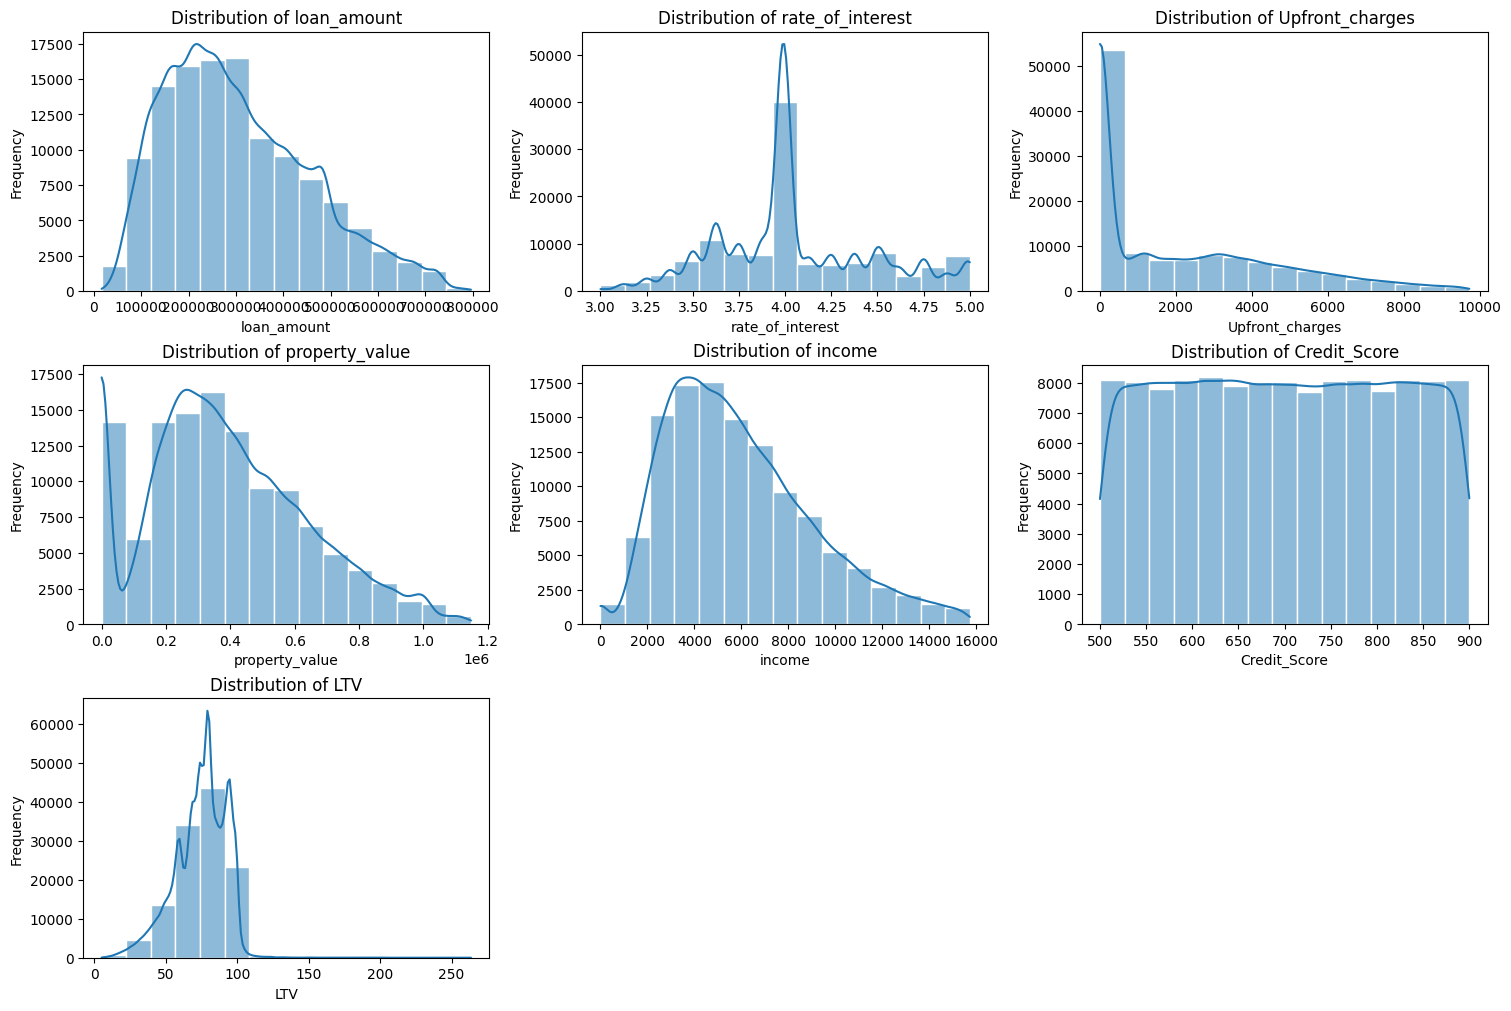

In [25]:
# numerical columns
col = ['loan_amount', 'rate_of_interest', 'Upfront_charges',
       'property_value', 'income', 'Credit_Score', 'LTV']

# Create a grid layout for subplots
n_cols = 3  # Number of columns in the grid
n_rows = 3  # Calculate required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), constrained_layout=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

sns.set_style('ticks')
sns.set_palette('Set2')

# Iterate over the columns and plot histograms
for i, c in enumerate(col):
    sns.histplot(df[c], kde=True, ax=axes[i], bins=15)
    axes[i].set_title(f"Distribution of {c}")
    axes[i].set_xlabel(c)
    axes[i].set_ylabel('Frequency')

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Display the plots
plt.show()

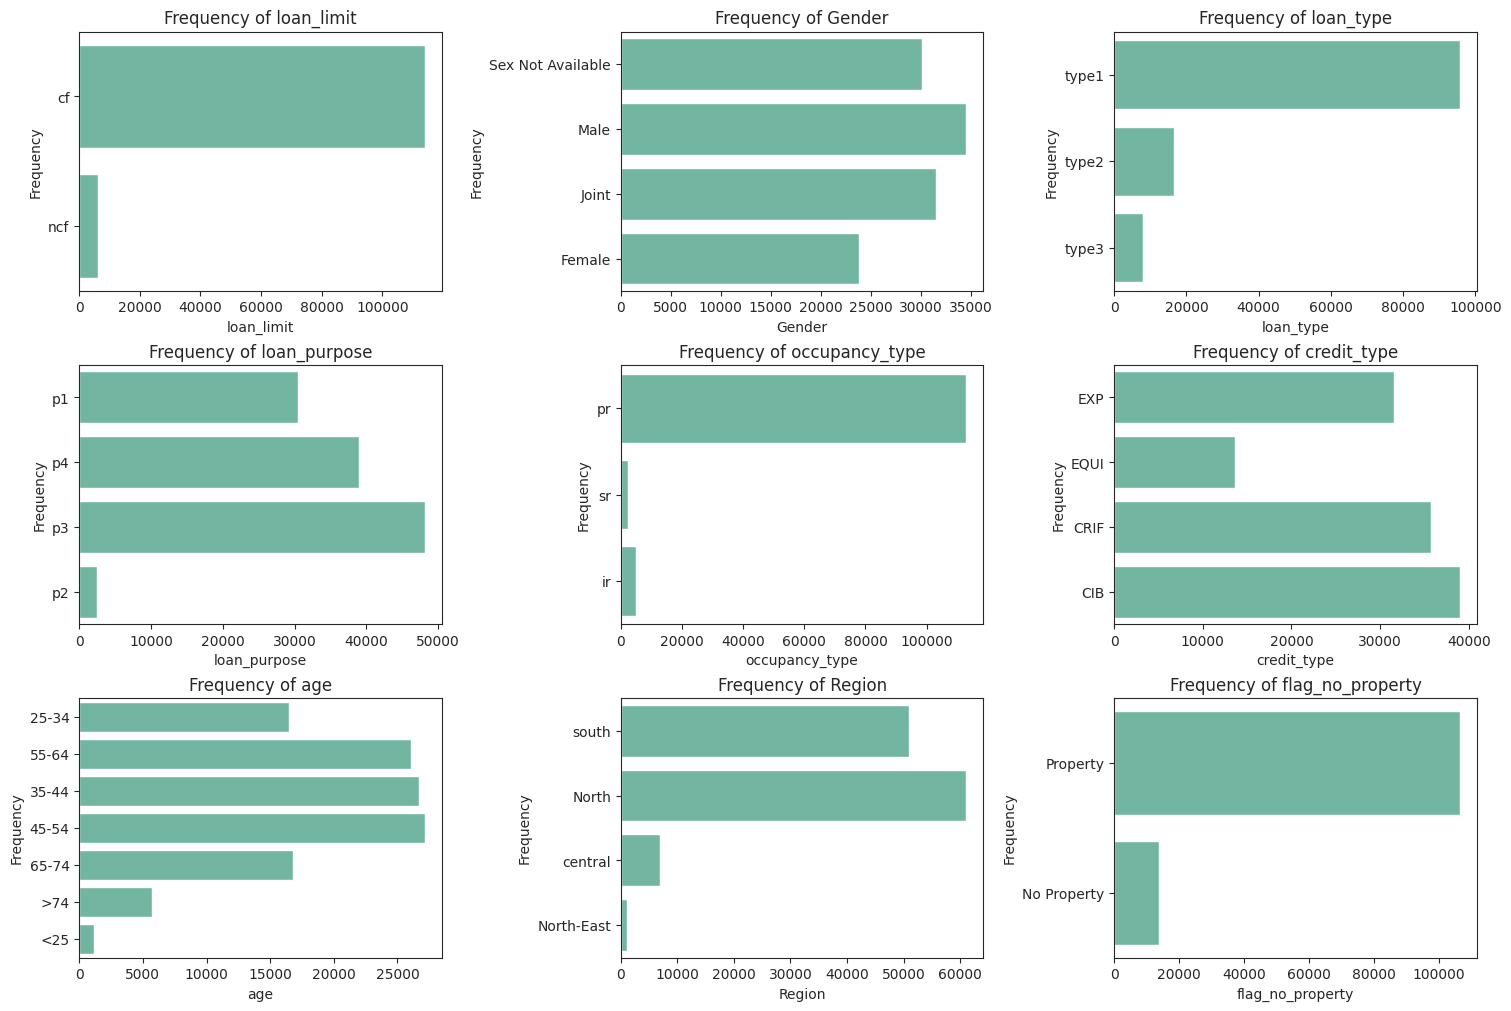

In [26]:
# categorical columns
col = ['loan_limit','Gender','loan_type','loan_purpose','occupancy_type','credit_type','age','Region','flag_no_property']

# Create a grid layout for subplots
n_cols = 3  # Number of columns in the grid
n_rows = 3  # Calculate required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), constrained_layout=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

sns.set_style('ticks')
sns.set_palette('Set2')

# Iterate over the columns and plot histograms
for i, c in enumerate(col):
    sns.countplot(df[c], ax=axes[i])
    axes[i].set_title(f"Frequency of {c}")
    axes[i].set_xlabel(c)
    axes[i].set_ylabel('Frequency')

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Display the plots
plt.show()

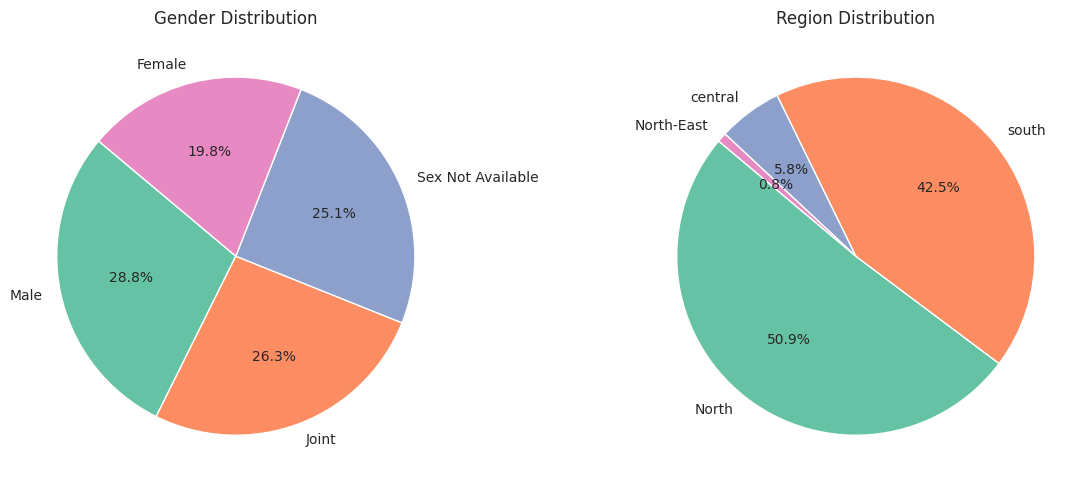

In [27]:


# Gender Distribution Pie Chart
gender_counts = df['Gender'].value_counts()
# Region Distribution Pie Chart
region_counts = df['Region'].value_counts()


plt.figure(figsize=(12, 5))
# Subplot for Gender
plt.subplot(1, 2, 1)
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=140
    #colors=['skyblue', 'lightpink']
)
plt.title('Gender Distribution')

# Subplot for Region
plt.subplot(1, 2, 2)
plt.pie(
    region_counts,
    labels=region_counts.index,
    autopct='%1.1f%%',
    startangle=140
    #colors=plt.cm.Paired.colors[:len(region_counts)]
)
plt.title('Region Distribution')

# Show the plots
plt.tight_layout()
plt.show()


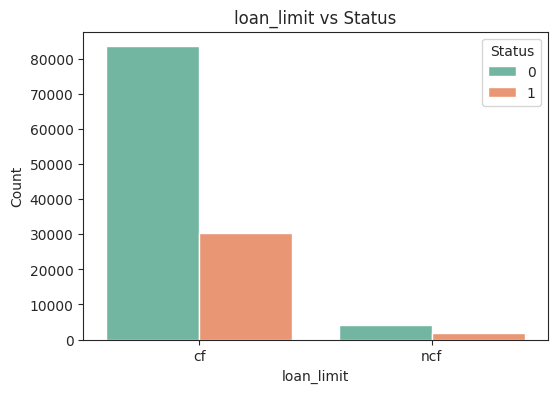

Chi-Square Test: loan_limit vs Status | Chi2: 58.1810, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant relationship between loan_limit and Status.



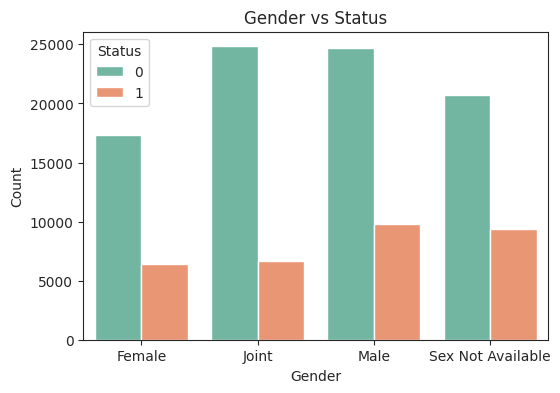

Chi-Square Test: Gender vs Status | Chi2: 837.7386, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant relationship between Gender and Status.



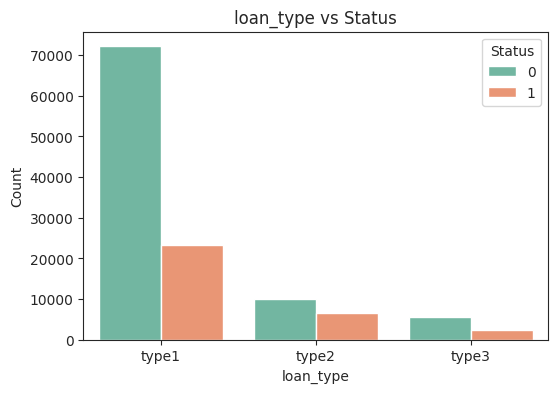

Chi-Square Test: loan_type vs Status | Chi2: 1638.8703, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant relationship between loan_type and Status.



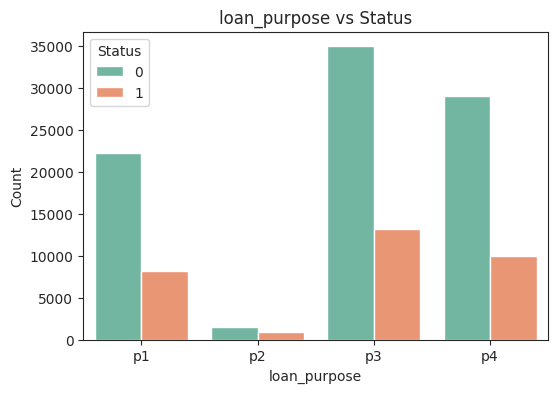

Chi-Square Test: loan_purpose vs Status | Chi2: 209.6501, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant relationship between loan_purpose and Status.



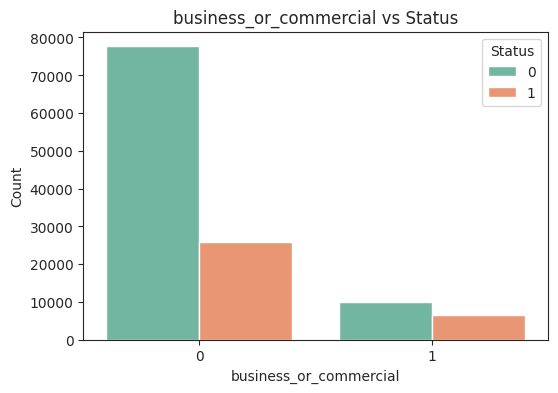

Chi-Square Test: business_or_commercial vs Status | Chi2: 1475.0149, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant relationship between business_or_commercial and Status.



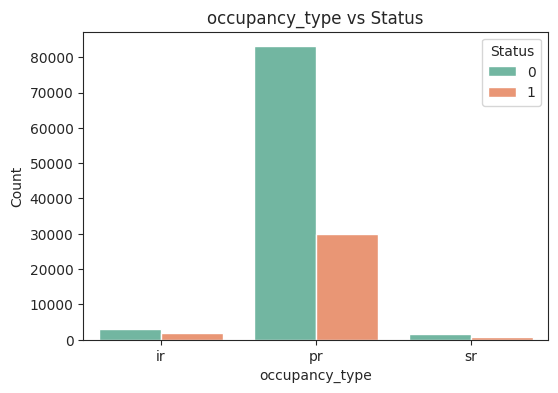

Chi-Square Test: occupancy_type vs Status | Chi2: 331.9323, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant relationship between occupancy_type and Status.



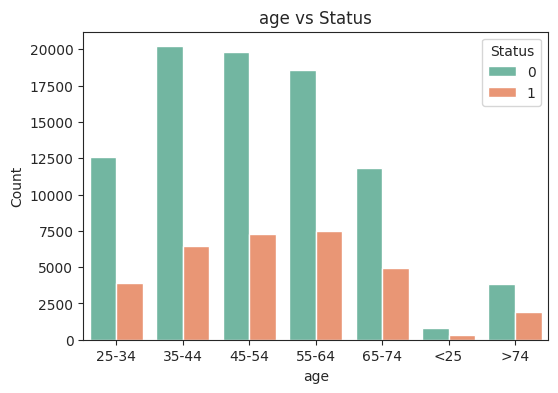

Chi-Square Test: age vs Status | Chi2: 393.8802, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant relationship between age and Status.



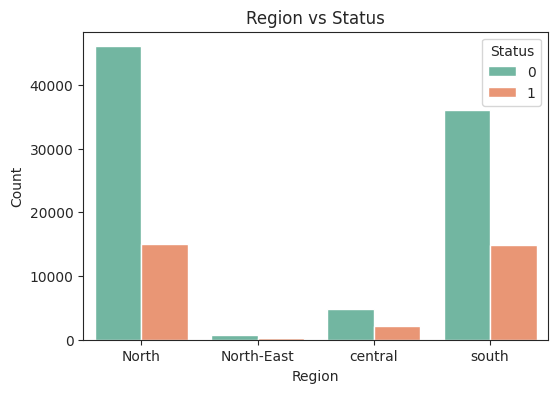

Chi-Square Test: Region vs Status | Chi2: 387.2415, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant relationship between Region and Status.



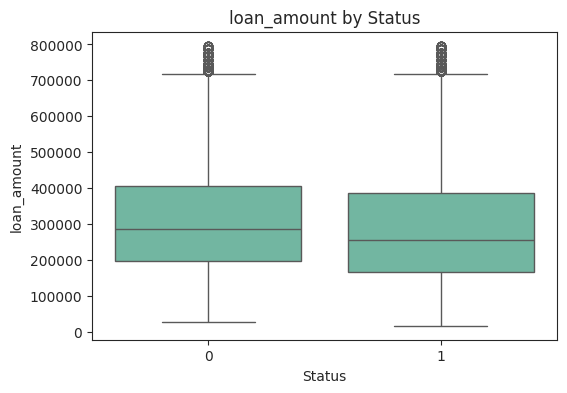

T-Test: loan_amount vs Status | T-stat: -20.6064, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant difference in loan_amount between 1 and 0.



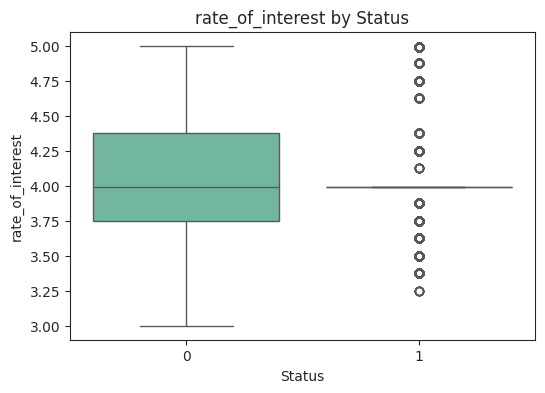

T-Test: rate_of_interest vs Status | T-stat: -30.6637, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant difference in rate_of_interest between 1 and 0.



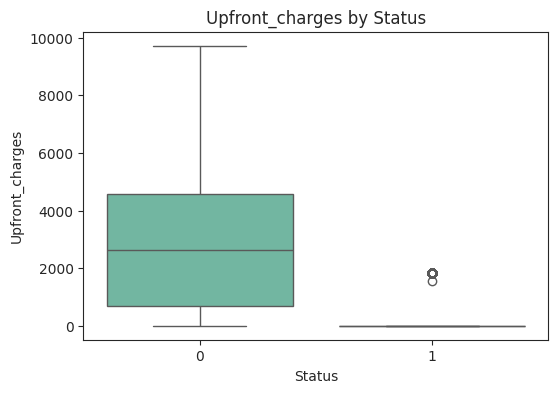

T-Test: Upfront_charges vs Status | T-stat: -211.5261, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant difference in Upfront_charges between 1 and 0.



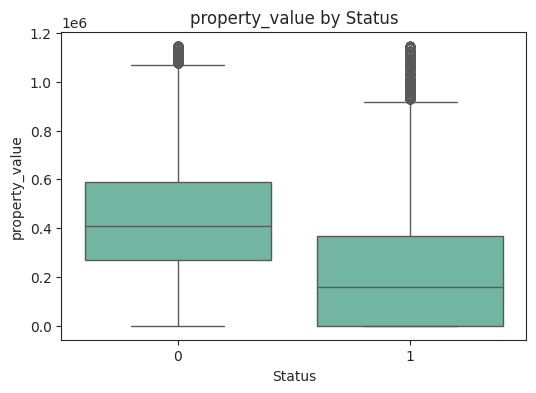

T-Test: property_value vs Status | T-stat: -149.1368, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant difference in property_value between 1 and 0.



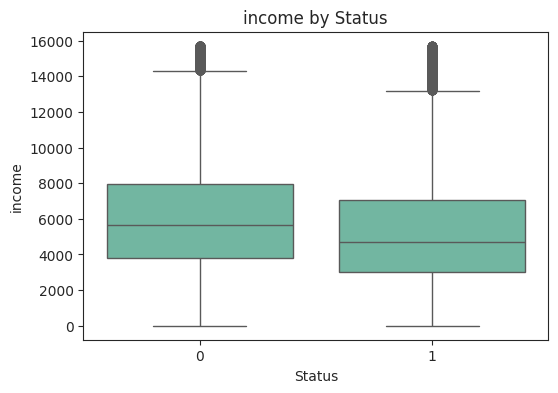

T-Test: income vs Status | T-stat: -44.1197, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant difference in income between 1 and 0.



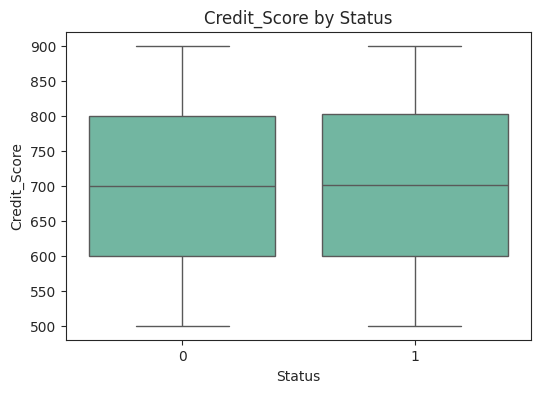

T-Test: Credit_Score vs Status | T-stat: 1.6231, p-value: 0.1046 -> 🟢 Fail to Reject Null Hypothesis
Inference: No significant difference in Credit_Score between 1 and 0.



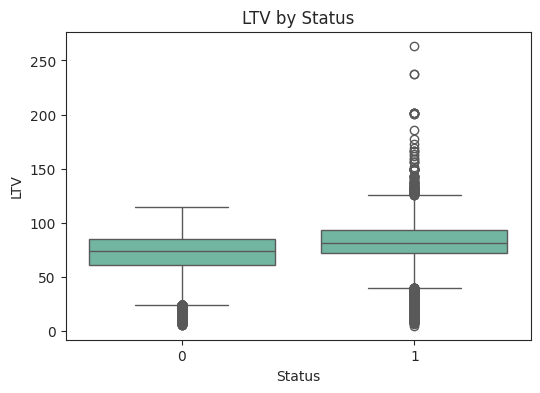

T-Test: LTV vs Status | T-stat: 64.4928, p-value: 0.0000 ->  🔴 Reject Null Hypothesis
Inference: There is a significant difference in LTV between 1 and 0.



In [28]:
cat_col = ['loan_limit', 'Gender', 'loan_type', 'loan_purpose', 'business_or_commercial', 'occupancy_type', 'age', 'Region']
num_col = ['loan_amount', 'rate_of_interest', 'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'LTV']
target_col = 'Status'

for col in cat_col:
    chi_square_test(df, col, target_col)

for col in num_col:
    ttest(df, col, target_col)

In [29]:
# Aggregate data
pt = df.groupby(['credit_type', 'co-applicant_credit_type', 'Status']).size().reset_index(name='Count')
pt = pt.pivot_table(index=['credit_type','co-applicant_credit_type'],columns='Status', values='Count', aggfunc='sum').reset_index()
pt[0] = pt[0].fillna(0)
a = np.array(pt[0])
b = np.array(pt[1])
sum_ab = np.sum([a, b], axis=0)
pt[0] = a / sum_ab * 100
pt[1] = b / sum_ab * 100
pt = pt.round(1)
pt.rename(columns={0:'Nondefaulters_%',1:'Defaulters_%'},inplace=True)
pt

###############
# CIB - CIBIL
# EQUI - Equifax
# EXP - Experian
# CRIF - CRIF


Status,credit_type,co-applicant_credit_type,Nondefaulters_%,Defaulters_%
0,CIB,CIB,80.6,19.4
1,CIB,EXP,85.8,14.2
2,CRIF,CIB,80.1,19.9
3,CRIF,EXP,85.5,14.5
4,EQUI,CIB,50.0,50.0
5,EQUI,EXP,0.0,100.0
6,EXP,CIB,80.0,20.0
7,EXP,EXP,85.3,14.7


- All the customers from the EQUI credit_type are defaulters

In [30]:
"""Additional Features"""

# 1. Loan-to-Income Ratio: The ratio of loan amount to income
df['LTI'] = df.apply(lambda x: 0 if x['income'] == 0 else x['loan_amount'] / x['income'], axis=1)

# 2. Loan Size Category: Categorizing loan sizes into small, medium, large, and very_large
df['loan_size'] = pd.cut(df['loan_amount'], bins=[0, 50000, 100000, 500000, float('inf')], labels=['small', 'medium', 'large', 'very_large'])

# 3. Loan-to-Value Ratio (LTV): The ratio of loan amount to property value
df['LTV_ratio'] = df['loan_amount'] / df['property_value']

# 4. Interaction between Loan Amount and Interest Rate: Capturing the interaction effect between loan amount and interest rate
df['loan_interest_interaction'] = df['loan_amount'] * df['rate_of_interest']

# 5. Average Loan Amount per Region: Calculating the average loan amount by region
df['avg_loan_per_region'] = df.groupby('Region')['loan_amount'].transform('mean')

# 6. Target Encoding for Loan Purpose: Encoding loan purpose by calculating the mean of 'Status' for each loan purpose
loan_purpose_avg = df.groupby('loan_purpose')['Status'].mean()
df['loan_purpose_encoded'] = df['loan_purpose'].map(loan_purpose_avg)

# 7. Missing Data Flag for Loan Purpose: Creating a binary flag to indicate missing data for loan purpose
df['missing_loan_purpose'] = df['loan_purpose'].isnull().astype(int)

# 8. Interaction between Income and Credit Score: Capturing the interaction effect between income and credit score
df['income_credit_score_interaction'] = df['income'] * df['Credit_Score']

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119994 entries, 0 to 148669
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   ID                               119994 non-null  int64   
 1   loan_limit                       119994 non-null  object  
 2   Gender                           119994 non-null  object  
 3   loan_type                        119994 non-null  object  
 4   loan_purpose                     119994 non-null  object  
 5   business_or_commercial           119994 non-null  int64   
 6   loan_amount                      119994 non-null  int64   
 7   rate_of_interest                 119994 non-null  float64 
 8   Upfront_charges                  119994 non-null  float64 
 9   property_value                   119994 non-null  float64 
 10  occupancy_type                   119994 non-null  object  
 11  income                           119994 non-null  float64


#### **Hypothesis Test Summary:**

| **Test**             | **Feature**               | **Target Variable** | **Test Statistic** | **p-value** | **Reject/Fail to Reject Null** | **Inference**                                                         |
|----------------------|---------------------------|---------------------|--------------------|-------------|--------------------------------|-----------------------------------------------------------------------|
| Chi-Square Test      | loan_limit                | Status              | 375.7879           | 0.0000      | 🔴 Reject H0                  | There is a significant relationship between loan_limit and Status.    |
| Chi-Square Test      | Gender                    | Status              | 899.8231           | 0.0000      | 🔴 Reject H0                  | There is a significant relationship between Gender and Status.        |
| Chi-Square Test      | loan_type                 | Status              | 2186.3039          | 0.0000      | 🔴 Reject H0                  | There is a significant relationship between loan_type and Status.     |
| Chi-Square Test      | loan_purpose              | Status              | 104.7480           | 0.0000      | 🔴 Reject H0                  | There is a significant relationship between loan_purpose and Status.  |
| Chi-Square Test      | business_or_commercial    | Status              | 1609.9173          | 0.0000      | 🔴 Reject H0                  | There is a significant relationship between business_or_commercial and Status. |
| Chi-Square Test      | occupancy_type            | Status              | 92.2940            | 0.0000      | 🔴 Reject H0                  | There is a significant relationship between occupancy_type and Status. |
| Chi-Square Test      | age                       | Status              | 368.4432           | 0.0000      | 🔴 Reject H0                  | There is a significant relationship between age and Status.          |
| Chi-Square Test      | Region                    | Status              | 353.5847           | 0.0000      | 🔴 Reject H0                  | There is a significant relationship between Region and Status.       |
| T-Test               | loan_amount               | Status              | -10.9990           | 0.0000      | 🔴 Reject H0                  | There is a significant difference in loan_amount between 1 and 0.     |
| T-Test               | rate_of_interest          | Status              | -37.0456           | 0.0000      | 🔴 Reject H0                  | There is a significant difference in rate_of_interest between 1 and 0. |
| T-Test               | Upfront_charges           | Status              | -188.2439          | 0.0000      | 🔴 Reject H0                  | There is a significant difference in Upfront_charges between 1 and 0. |
| T-Test               | property_value            | Status              | -108.3462          | 0.0000      | 🔴 Reject H0                  | There is a significant difference in property_value between 1 and 0. |
| T-Test               | income                    | Status              | -24.3737           | 0.0000      | 🔴 Reject H0                  | There is a significant difference in income between 1 and 0.         |
| T-Test               | Credit_Score              | Status              | 1.4808             | 0.1387      | 🟢 Fail to Reject H0           | No significant difference in Credit_Score between 1 and 0.           |
| T-Test               | LTV                       | Status              | 71.4305            | 0.0000      | 🔴 Reject H0                  | There is a significant difference in LTV between 1 and 0.            |


---

1. **Chi-Square Test Results:**
   - All the categorical variables (`loan_limit`, `Gender`, `loan_type`, etc.) exhibit **strong significant relationships** with the target variable `Status` (p-value < 0.05). In each case, the null hypothesis is **rejected (🔴 Reject H0)**, implying that these features are statistically associated with the outcome variable.

2. **T-Test Results for Numerical Variables:**
   - Variables like `loan_amount`, `rate_of_interest`, and `Upfront_charges` demonstrate **significant differences** in mean values between the two groups of the `Status` target (p-value < 0.05), leading to the **rejection of the null hypothesis (🔴 Reject H0)**. These features are influential in predicting `Status`.

3. **Non-Significant Result:**
   - The `Credit_Score` feature has a **non-significant result** with a p-value of 0.1387, leading to the **failure to reject the null hypothesis (🟢 Fail to Reject H0)**. This suggests that `Credit_Score` does not significantly differ across `Status` categories, and therefore may not be a strong predictor.

4. **Inference and Implications:**
   - Features that **reject the null hypothesis** (🔴 Reject H0) suggest that they **significantly influence** or **predict** the `Status` variable, implying their importance in model building for classification or regression tasks. Conversely, `Credit_Score` does not significantly affect `Status`, which might lead to its exclusion from predictive modeling or further exploration.

### **6.2 - Multivariant Analysis**

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119994 entries, 0 to 148669
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   ID                               119994 non-null  int64   
 1   loan_limit                       119994 non-null  object  
 2   Gender                           119994 non-null  object  
 3   loan_type                        119994 non-null  object  
 4   loan_purpose                     119994 non-null  object  
 5   business_or_commercial           119994 non-null  int64   
 6   loan_amount                      119994 non-null  int64   
 7   rate_of_interest                 119994 non-null  float64 
 8   Upfront_charges                  119994 non-null  float64 
 9   property_value                   119994 non-null  float64 
 10  occupancy_type                   119994 non-null  object  
 11  income                           119994 non-null  float64

In [32]:
df.Status.value_counts(normalize = True)

,proportion
Status,
0,0.730578
1,0.269422


### **6.3 - Solving Bias Problem - To study the Borrower Characteristics**

In [33]:
# Assuming df is your DataFrame and 'Status' is the column you're interested in

# Step 1: Find the counts of each class
class_0_count = (df['Status'] == 0).sum()
class_1_count = (df['Status'] == 1).sum()

# Step 2: Decide on your desired balance
if class_0_count > class_1_count:
    # Undersample class 0 (majority class)
    majority_class = df[df['Status'] == 0]
    minority_class = df[df['Status'] == 1]

    # Randomly sample from the majority class to match the size of the minority class
    majority_class_undersampled = majority_class.sample(class_1_count, random_state=42)

    # Combine the undersampled majority class with the minority class
    balanced_df = pd.concat([majority_class_undersampled, minority_class])

elif class_1_count > class_0_count:
    # Oversample class 1 (minority class)
    majority_class = df[df['Status'] == 0]
    minority_class = df[df['Status'] == 1]

    # Randomly sample from the minority class to match the size of the majority class
    minority_class_oversampled = minority_class.sample(class_0_count, replace=True, random_state=42)

    # Combine the oversampled minority class with the majority class
    balanced_df = pd.concat([majority_class, minority_class_oversampled])

# Step 3: Shuffle the dataset to mix the classes
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [34]:
balanced_df.Status.value_counts(normalize = True)

,proportion
Status,
0,0.5
1,0.5


In [35]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64658 entries, 0 to 64657
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ID                               64658 non-null  int64   
 1   loan_limit                       64658 non-null  object  
 2   Gender                           64658 non-null  object  
 3   loan_type                        64658 non-null  object  
 4   loan_purpose                     64658 non-null  object  
 5   business_or_commercial           64658 non-null  int64   
 6   loan_amount                      64658 non-null  int64   
 7   rate_of_interest                 64658 non-null  float64 
 8   Upfront_charges                  64658 non-null  float64 
 9   property_value                   64658 non-null  float64 
 10  occupancy_type                   64658 non-null  object  
 11  income                           64658 non-null  float64 
 12  cred

#### **a. Gender (categorical) vs Age (categorical) vs Status (categorical)**

In [36]:
d = df.groupby(['Gender','age'])['Status'].value_counts(normalize=False).reset_index()

pvt_0 = pd.pivot_table(data = d[d["Status"]==0],
         index = ["Gender"],
         columns = ['age'],
         values = 'count',
               aggfunc = "mean"
         )

pvt_1 = pd.pivot_table(data = d[d["Status"]==1],
         index = ["Gender"],
         columns = ['age'],
         values = 'count',
               aggfunc = "mean"
         )

pvt_0 = pvt_0[['<25','25-34', '35-44', '45-54', '55-64', '65-74',  '>74']]
pvt_1 = pvt_1[['<25','25-34', '35-44', '45-54', '55-64', '65-74',  '>74']]

cm = sns.diverging_palette(250, 10, as_cmap=True)  # 250 (Red) -> 10 (Green)

styled_df = df.style.background_gradient(cmap=cm).format("{:.2f}")  # Format to 2 decimal places
styled_pvt_0 = pvt_0.style.background_gradient(cmap=cm).format("{:.2f}").highlight_null('red')  # Highlight null values
styled_pvt_1 = pvt_1.style.background_gradient(cmap=cm).format("{:.2f}").highlight_null('red')  # Highlight null values

In [37]:
text = "### <font color = 'Blue' size = 5>Non-defaulters</font>"
display(Markdown(text))
display(styled_pvt_0)

### <font color = 'Blue' size = 5>Non-defaulters</font>

age,<25,25-34,35-44,45-54,55-64,65-74,>74
Gender,,,,,,,
Female,148.00,2080.00,3484.00,4046.00,4144.00,2610.00,840.00
Joint,198.00,3927.00,6137.00,5366.00,4767.00,3364.00,1069.00
Male,345.00,4453.00,6383.00,5741.00,4623.00,2410.00,778.00
Sex Not Available,140.00,2101.00,4202.00,4677.00,5038.00,3441.00,1153.00


1. Males tend to have higher non-default rates across most age groups compared to females.  
2. Non-defaulters decrease with age, particularly in the 65-74 and >74 age groups.  
3. The "Sex Not Available" category has consistently high non-defaulter counts, suggesting potential data reporting issues.

In [38]:
text = "### <font color = 'Blue' size = 5>Defaulters</font>"
display(Markdown(text))
display(styled_pvt_1)

### <font color = 'Blue' size = 5>Defaulters</font>

age,<25,25-34,35-44,45-54,55-64,65-74,>74
Gender,,,,,,,
Female,65.00,673.00,1160.00,1497.00,1586.00,1063.00,393.00
Joint,60.00,889.00,1337.00,1459.00,1482.00,1071.00,389.00
Male,165.00,1424.00,2198.00,2259.00,2082.00,1192.00,476.00
Sex Not Available,69.00,910.00,1773.00,2085.00,2332.00,1613.00,627.00


1. Defaulters peak in the 35-54 age group across all genders.  
2. Default rates decrease with age, especially after 55.  

#### **b. Loan Size (categorical) vs Rate of Interest (numerical) vs Status (categorical)**


- The rate of interest decreases with the increase in loan size.
- The defaulters are concentrated at 4% rate of interest, across loan_size


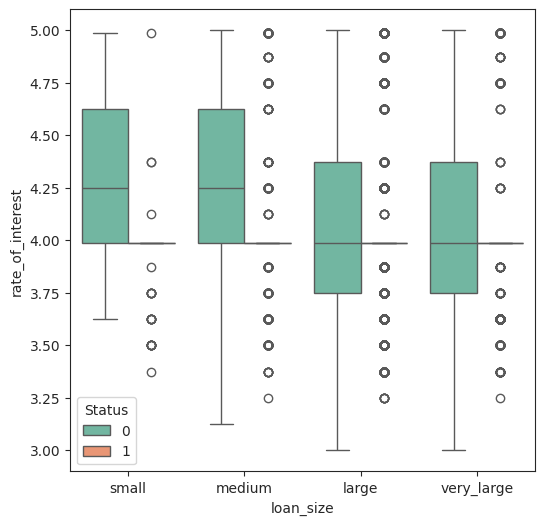

In [39]:
# Loan size and rate of interest
plt.figure(figsize=(6, 6))
sns.boxplot(data=balanced_df, x='loan_size', y='rate_of_interest', hue='Status')

text = """
- The rate of interest decreases with the increase in loan size.
- The defaulters are concentrated at 4% rate of interest, across loan_size
"""
# display(pvt.round())
display(Markdown(text))

#### **c . Loan Amount (numerical) vs Loan Purpose (categorical) vs Status(categorical)**

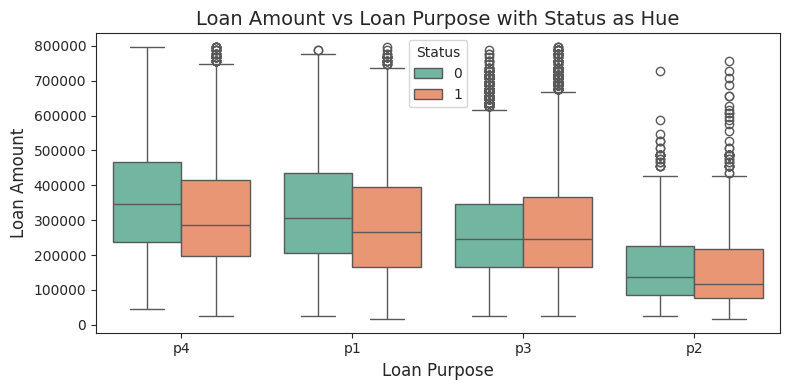

Status,0,1
loan_purpose,,
p1,296500.0,266500.0
p2,136500.0,116500.0
p3,246500.0,246500.0
p4,346500.0,286500.0



1. **Non-defaulters have higher loan amounts** than defaulters across all loan purposes, except for `p3`.
2. **Loan amounts for `p3` are the same** for both non-defaulters and defaulters, suggesting other factors may influence defaults in this category.


In [40]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=balanced_df, x="loan_purpose", y="loan_amount", hue="Status", palette="Set2")
plt.title("Loan Amount vs Loan Purpose with Status as Hue", fontsize=14)
plt.xlabel("Loan Purpose", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)
plt.legend(title="Status")
plt.tight_layout()
plt.show()


d = df.groupby(['loan_purpose','Status'])['loan_amount'].median().reset_index()
pvt = pd.pivot_table(data = d,
         index = ["loan_purpose"],
         columns = ['Status'],
         values = 'loan_amount',
          aggfunc = "mean").round()


text = """
1. **Non-defaulters have higher loan amounts** than defaulters across all loan purposes, except for `p3`.
2. **Loan amounts for `p3` are the same** for both non-defaulters and defaulters, suggesting other factors may influence defaults in this category.
"""

display(pvt)
display(Markdown(text))

#### **d. Loan amount (numerical)  vs Property (numerical) value vs Status (categorical)**

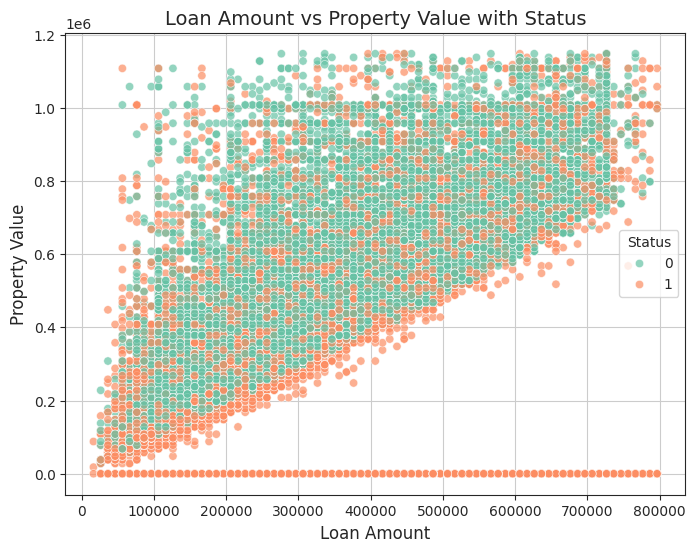

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=balanced_df, x='loan_amount', y='property_value', hue='Status', sizes=(20, 200), palette='Set2', alpha=0.7)
plt.title('Loan Amount vs Property Value with Status', fontsize=14)
plt.xlabel('Loan Amount', fontsize=12)
plt.ylabel('Property Value', fontsize=12)
plt.legend(title='Status', fontsize=10)
plt.grid(True)
plt.show()

Defaulters are often individuals with no property value, which poses a higher risk to lenders due to the absence of collateral to recover the loan amount.

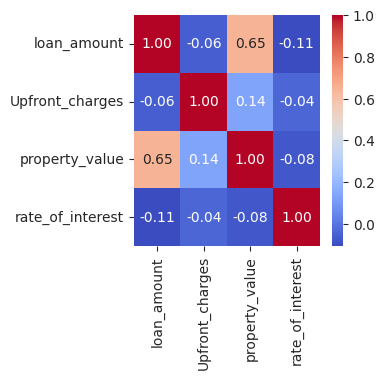

In [42]:
df_numeric = df[['loan_amount','Upfront_charges','property_value','rate_of_interest']]

# Set figure size to make the heatmap wider
plt.figure(figsize=(3, 3))

# Create a heatmap
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.show()



- **Loan amount and property value** show a moderate positive correlation (0.65), indicating that higher property values are associated with larger loan amounts.  
- **Upfront charges** and other variables, including loan amount and property value, exhibit weak correlations, suggesting little to no linear relationship.  
- **Rate of interest** shows a weak or negligible correlation with all other variables, indicating it is likely influenced by factors outside of these parameters.

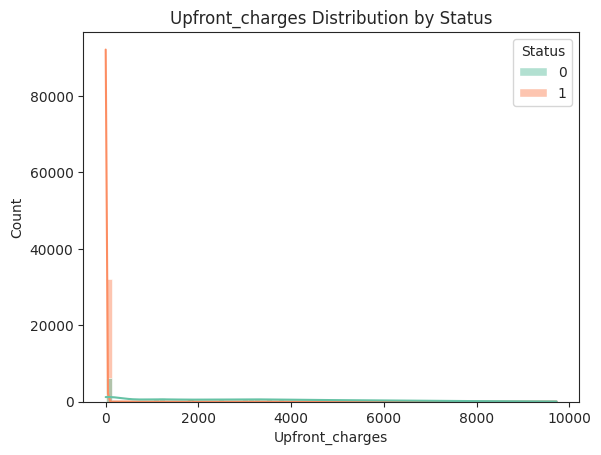

Most Defaulters don't pay upfront charges

In [43]:
# Create the histogram with a kernel density estimate (KDE)
sns.histplot(balanced_df, x='Upfront_charges', hue='Status', kde=True)

# Set the title and adjust the x-axis scale to logarithmic
plt.title('Upfront_charges Distribution by Status')
# plt.xscale("log")
plt.show()

# Display a Markdown text
text = """Most Defaulters don't pay upfront charges"""
display(Markdown(text))

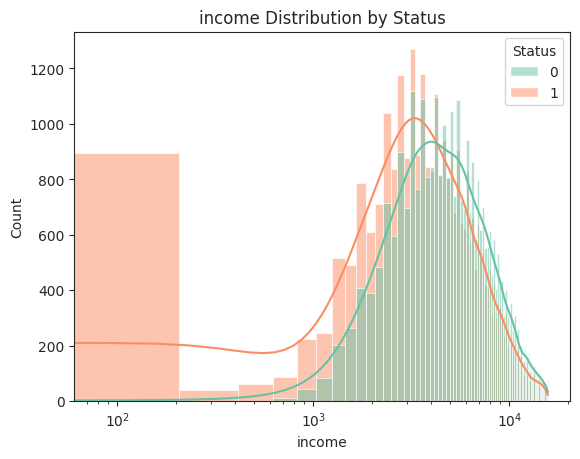

Most Defaulters belong to lower income bracket (approx 120 units)

In [44]:
sns.histplot(balanced_df, x='income', hue='Status', kde=True)
plt.title('income Distribution by Status')
plt.xscale("log")
plt.show()

text = """Most Defaulters belong to lower income bracket (approx 120 units)"""
display(Markdown(text))


#### **e. LTI Distribution vs Status by loan_sizes**

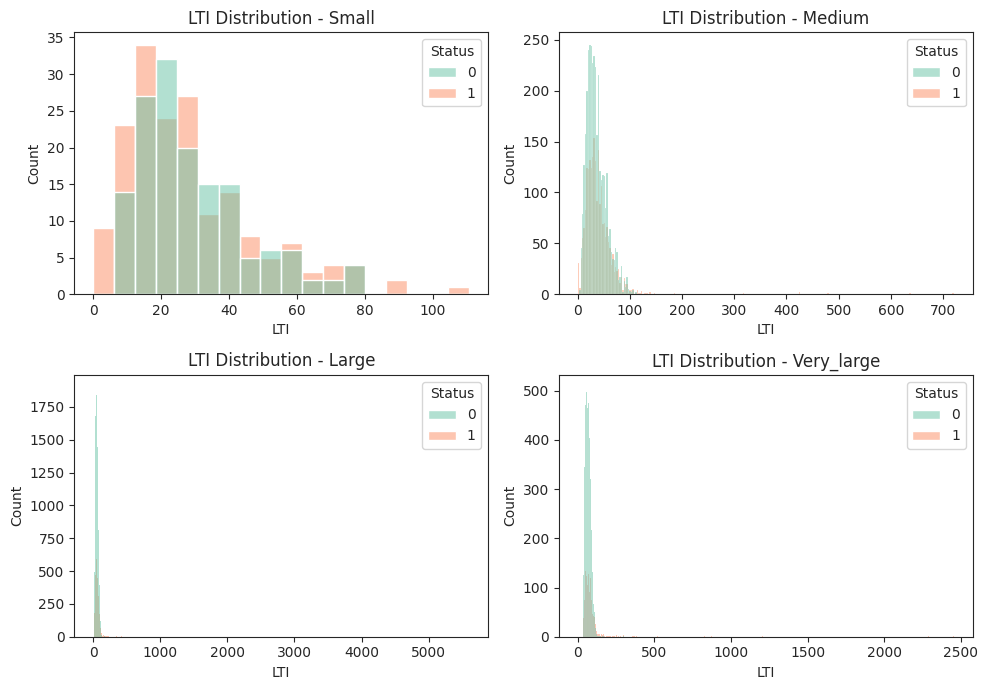

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

loan_sizes = ['small', 'medium', 'large', 'very_large']

for i, loan_size in enumerate(loan_sizes):
    temp_df = df[df['loan_size'] == loan_size]
    ax = axes[i // 2, i % 2]  # Determine position in the 2x2 grid
    sns.histplot(temp_df, x='LTI', hue='Status', kde=False, ax=ax)
    # ax.set_xscale('log')
    ax.set_title(f'LTI Distribution - {loan_size.capitalize()}')

plt.tight_layout()
plt.show()

- The **LTI ratio** is higher in the **small loan amount** category, indicating that borrowers with smaller loans tend to have **lower incomes** relative to the loan amount.
- The **LTI ratio** improves in the **medium, large, and very large loan** categories, suggesting that borrowers in these groups generally have **higher income levels**, allowing them to manage larger loans more comfortably.

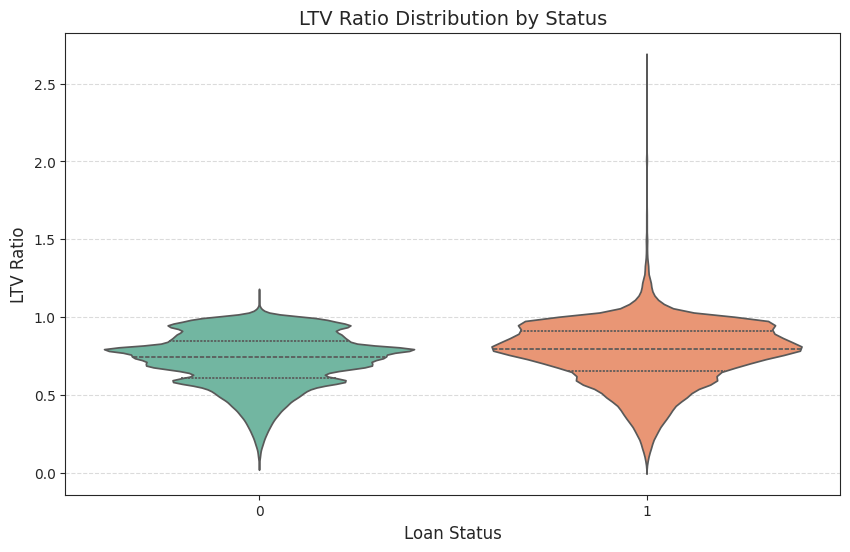

In [46]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Status', y='LTV_ratio', palette='Set2', inner="quartile")
plt.title('LTV Ratio Distribution by Status', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('LTV Ratio', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


- An LTV below 1 indicates a loan amount less than the property's value, suggesting lower risk for lenders and higher equity for borrowers.
- However, for defaulters, the property value is less than the loan amount, implying an LTV of 1, which increases the risk for both lenders and borrowers.

### **7. Status Classfication Model**

In [47]:
######################################################################################

# Misc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ML Performance Metrics
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# ML Classification Algorithm
from xgboost import XGBClassifier

######################################################################################

# Handle missing values (fixed warning)
df['loan_purpose_encoded'] = df['loan_purpose_encoded'].fillna(df['loan_purpose_encoded'].mean())

# Encode categorical variables
categorical_cols = ['loan_limit', 'Gender', 'loan_type', 'loan_purpose', 'occupancy_type',
                    'credit_type', 'co-applicant_credit_type', 'age', 'Region',
                    'flag_no_property', 'loan_size' , "business_or_commercial"]

encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

######################################################################################

# Define features and target
X = df.drop(columns=['ID', 'Status'])  # Exclude ID and target column
y = df['Status']                      # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Replace infinite values with NaN before scaling
X_train[numerical_cols] = X_train[numerical_cols].replace([np.inf, -np.inf], np.nan)
X_test[numerical_cols] = X_test[numerical_cols].replace([np.inf, -np.inf], np.nan)

######################################################################################

# Impute NaN values with the mean (or median) of the column
X_train[numerical_cols] = X_train[numerical_cols].fillna(X_train[numerical_cols].mean())
X_test[numerical_cols] = X_test[numerical_cols].fillna(X_test[numerical_cols].mean())

######################################################################################

# Apply StandardScaler
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

######################################################################################

# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Store results in a DataFrame
results = {
    'Model': 'XGBoost',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC AUC': roc_auc
}

results_df = pd.DataFrame([results])

######################################################################################

# Print results
print("Model Performance Metrics:")
display(results_df)

print("\n")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(feature_importance)


Model Performance Metrics:


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,XGBoost,0.982041,0.947782,0.987786,0.967371,0.997517





XGBoost Feature Importance:
                            Feature  Importance
7                   Upfront_charges    0.803674
8                    property_value    0.046077
9                    occupancy_type    0.038870
6                  rate_of_interest    0.038787
23             loan_purpose_encoded    0.011533
4            business_or_commercial    0.010835
3                      loan_purpose    0.010033
14                              age    0.006347
2                         loan_type    0.005707
1                            Gender    0.004235
0                        loan_limit    0.003273
10                           income    0.002459
20                        LTV_ratio    0.002185
22              avg_loan_per_region    0.002100
15                              LTV    0.001972
18                              LTI    0.001689
5                       loan_amount    0.001636
13         co-applicant_credit_type    0.001427
19                        loan_size    0.001328
25  incom

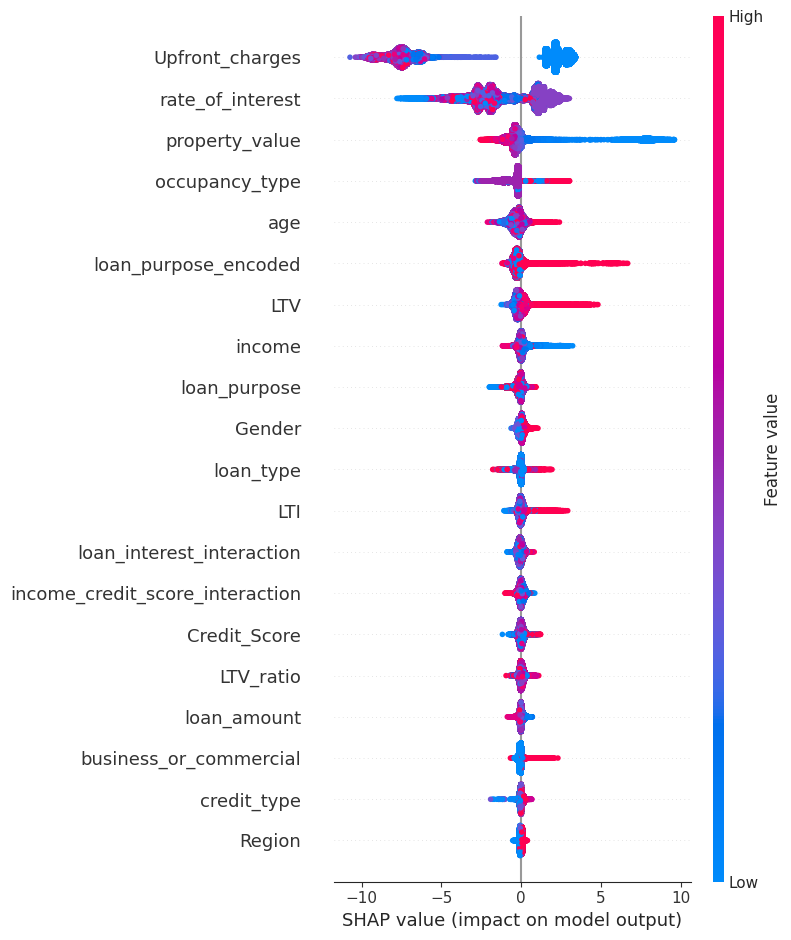

In [48]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

# Plot feature importance
shap.summary_plot(shap_values, X_train)

\begin{aligned}
\hat{y_i} = & \ 0.803674 \cdot f_{\text{Upfront_charges}}(i) + \\
             & 0.046077 \cdot f_{\text{property_value}}(i) + \\
             & 0.038870 \cdot f_{\text{occupancy_type}}(i) + \\
             & 0.038787 \cdot f_{\text{rate_of_interest}}(i) + \\
             & 0.011533 \cdot f_{\text{loan_purpose_encoded}}(i) + \\
             & 0.010835 \cdot f_{\text{business_or_commercial}}(i) + \\
             & 0.010033 \cdot f_{\text{loan_purpose}}(i) + \\
             & 0.006347 \cdot f_{\text{age}}(i) + \\
             & 0.005707 \cdot f_{\text{loan_type}}(i) + \\
             & 0.004235 \cdot f_{\text{Gender}}(i) + \\
             & 0.003273 \cdot f_{\text{loan_limit}}(i) + \\
             & 0.002459 \cdot f_{\text{income}}(i) + \\
             & 0.002185 \cdot f_{\text{LTV_ratio}}(i) + \\
             & 0.002100 \cdot f_{\text{avg_loan_per_region}}(i) + \\
             & 0.001972 \cdot f_{\text{LTV}}(i) + \\
             & 0.001689 \cdot f_{\text{LTI}}(i) + \\
             & 0.001636 \cdot f_{\text{loan_amount}}(i) + \\
             & 0.001427 \cdot f_{\text{co-applicant_credit_type}}(i) + \\
             & 0.001328 \cdot f_{\text{loan_size}}(i) + \\
             & 0.001278 \cdot f_{\text{income_credit_score_interaction}}(i) + \\
             & 0.001255 \cdot f_{\text{Region}}(i) + \\
             & 0.001141 \cdot f_{\text{loan_interest_interaction}}(i) + \\
             & 0.001107 \cdot f_{\text{Credit_Score}}(i) + \\
             & 0.001052 \cdot f_{\text{credit_type}}(i) + \\
             & 0.000000 \cdot f_{\text{flag_no_property}}(i) + \\
             & 0.000000 \cdot f_{\text{missing_loan_purpose}}(i)
\end{aligned}

<br>
<br>

**Comments on the Weights and Variables:**

1. **Upfront Charges (Weight: 0.803674)**: This variable has the largest weight, indicating it strongly influences the predicted status. A higher upfront charge increases the predicted value significantly.

2. **Property Value (Weight: 0.046077)**: With a smaller weight, **property_value** plays a minor role in the prediction, suggesting it's less important than upfront charges.

3. **Occupancy Type (Weight: 0.038870)**: The coefficient for **occupancy_type** is also small, showing it has a limited effect on the predicted outcome.

4. **Rate of Interest (Weight: 0.038787)**: **Rate_of_interest** has the smallest weight, indicating it's the least influential factor in this model.

---

> ### **Summary**:
**Upfront Charges** have the strongest impact on predicting the outcome, while **Property Value**, **Occupancy Type**, and **Rate of Interest** have much smaller effects.

---
<br>
<br>
